# The Kumaraswamy Distribution
Reference the [Kumaraswamy Wikipedia Page](https://en.wikipedia.org/wiki/Kumaraswamy_distribution).

## Imports

In [1]:
from qmcpy import *
from scipy.special import gamma
from numpy import *

In [2]:
import matplotlib
from matplotlib import pyplot
%matplotlib inline
pyplot.rc('font', size=16)          # controls default text sizes
pyplot.rc('axes', titlesize=16)     # fontsize of the axes title
pyplot.rc('axes', labelsize=16)     # fontsize of the x and y labels
pyplot.rc('xtick', labelsize=16)    # fontsize of the tick labels
pyplot.rc('ytick', labelsize=16)    # fontsize of the tick labels
pyplot.rc('legend', fontsize=16)    # legend fontsize
pyplot.rc('figure', titlesize=16)   # fontsize of the figure title

## 2D Density Plot

In [3]:
def plt_2d_kumaraswamy(kamaraswamy,n):
    print(kamaraswamy)
    n_mesh = 502
    # Points
    t = kamaraswamy.gen_samples(n)
    # PDF
    mesh = zeros(((n_mesh)**2,3),dtype=float)
    grid_tics = linspace(0,1,n_mesh)
    x_mesh,y_mesh = meshgrid(grid_tics,grid_tics)
    mesh[:,0] = x_mesh.flatten()
    mesh[:,1] = y_mesh.flatten()
    mesh[:,2] = kamaraswamy._weight(mesh[:,:2])
    z_mesh = mesh[:,2].reshape((n_mesh,n_mesh))
    # plots
    fig,ax = pyplot.subplots(figsize=(7,7),nrows=1,ncols=1)
    #   colors 
    clevel = arange(mesh[:,2].min(),mesh[:,2].max(),.025)
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", [(.95,.95,.95),(0,0,1)]) #cmap = pyplot.get_cmap('Blues')
    #   contour + scatter plot
    ax.contourf(x_mesh,y_mesh,z_mesh,clevel,cmap=cmap,extend='both')
    ax.scatter(t[:,0],t[:,1],s=5,color='w')
    #   axis
    for nsew in ['top','bottom','left','right']: ax.spines[nsew].set_visible(False)
    ax.xaxis.set_ticks_position('none') 
    ax.yaxis.set_ticks_position('none') 
    ax.set_aspect(1)
    ax.set_xlim([0,1])
    ax.set_xticks([0,1])
    ax.set_ylim([0,1])
    ax.set_yticks([0,1])
    #   labels
    ax.set_xlabel('$T_1$')
    ax.set_ylabel('$T_2$')
    ax.set_title('Kamaraswamy PDF and Random Samples')
    #   metas
    fig.tight_layout()

Kumaraswamy (TrueMeasure Object)
    a               [2 3]
    b               [3 5]


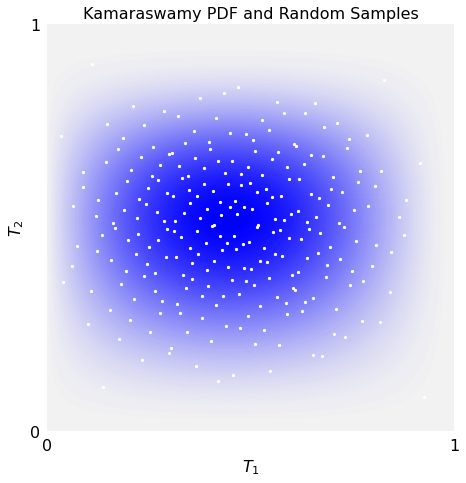

In [4]:
kumaraswamy = Kumaraswamy(Sobol(2),a=[2,3],b=[3,5]) # won't plot correctly with multiple composed transforms
plt_2d_kumaraswamy(kumaraswamy,n=2**8)

## 1D Kumaraswamy Expected Value 

In [5]:
a,b = 2,6
abs_tol = 1e-6
cf = CustomFun(true_measure=Kumaraswamy(Sobol(1),a,b), g=lambda x:x)
sol,data = CubQMCSobolG(cf,abs_tol=abs_tol).integrate()
print(data)
true_val = b*gamma(1+1/a)*gamma(b)/gamma(1+1/a+b)
error = abs(true_val-sol)
if error>abs_tol: raise Exception("QMC error %.3f not within tolerance."%error)

Solution: 0.3410         
CustomFun (Integrand Object)
Sobol (DiscreteDistribution Object)
    d               1
    randomize       1
    graycode        0
    seed            96725
    mimics          StdUniform
    dim0            0
Kumaraswamy (TrueMeasure Object)
    a               2^(1)
    b               6
CubQMCSobolG (StoppingCriterion Object)
    abs_tol         1.00e-06
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
LDTransformData (AccumulateData Object)
    n_total         2^(17)
    solution        0.341
    error_bound     4.69e-07
    time_integrate  0.033


## Importance Samling with a Single Kumaraswamy

In [6]:
# compose with a Kumaraswamy transformation
abs_tol = 1e-4
cf = CustomFun(Uniform(Kumaraswamy(Sobol(1,seed=7),a=.5,b=.5)), g=lambda x:x)
sol,data = CubQMCSobolG(cf,abs_tol=abs_tol).integrate() 
print(data)
true_val = .5 # expected value of standard uniform
error = abs(true_val-sol)
if error>abs_tol: raise Exception("QMC error %.3f not within tolerance."%error)

Solution: 0.5000         
CustomFun (Integrand Object)
Sobol (DiscreteDistribution Object)
    d               1
    randomize       1
    graycode        0
    seed            61616
    mimics          StdUniform
    dim0            0
Uniform (TrueMeasure Object)
    lower_bound     0
    upper_bound     1
    transform       Kumaraswamy (TrueMeasure Object)
                       a               2^(-1)
                       b               2^(-1)
CubQMCSobolG (StoppingCriterion Object)
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
LDTransformData (AccumulateData Object)
    n_total         2^(11)
    solution        0.500
    error_bound     1.40e-05
    time_integrate  0.035


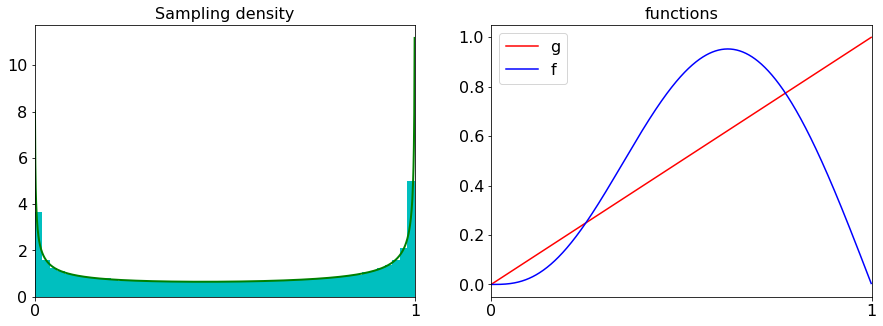

In [7]:
# plot the above functions
x = linspace(0,1,1000).reshape(-1,1)
x = x[1:-1] # plotting locations
# plot
fig,ax = pyplot.subplots(ncols=2,figsize=(15,5))
#    density
rho = cf.true_measure.transform._weight(x)
tfvals = cf.true_measure.transform._transform_r(x)
ax[0].hist(tfvals,density=True,bins=50,color='c')
ax[0].plot(x,rho,color='g',linewidth=2)
ax[0].set_title('Sampling density')
#    functions
gs = cf.g(x)
fs = cf.f(x)
ax[1].plot(x,gs,color='r',label='g')
ax[1].plot(x,fs,color='b',label='f')
ax[1].legend()
ax[1].set_title('functions');
# metas
for i in range(2):
    ax[i].set_xlim([0,1])
    ax[i].set_xticks([0,1])

## Importance Sampling with 2 (Composed) Kumaraswamys

In [8]:
# compose multiple Kumaraswamy distributions
abs_tol = 1e-3
dd = Sobol(1,seed=7)
t1 = Kumaraswamy(dd,a=.5,b=.5) # first transformation
t2 = Kumaraswamy(t1,a=5,b=2) # second transformation
cf = CustomFun(Uniform(t2), g=lambda x:x)
sol,data = CubQMCSobolG(cf,abs_tol=abs_tol).integrate() # expected value of standard uniform
print(data)
true_val = .5
error = abs(true_val-sol)
if error>abs_tol: raise Exception("QMC error %.3f not within tolerance."%error)

Solution: 0.4998         
CustomFun (Integrand Object)
Sobol (DiscreteDistribution Object)
    d               1
    randomize       1
    graycode        0
    seed            61616
    mimics          StdUniform
    dim0            0
Uniform (TrueMeasure Object)
    lower_bound     0
    upper_bound     1
    transform       Kumaraswamy (TrueMeasure Object)
                       a               5
                       b               2^(1)
                       transform       Kumaraswamy (TrueMeasure Object)
                                          a               2^(-1)
                                          b               2^(-1)
CubQMCSobolG (StoppingCriterion Object)
    abs_tol         0.001
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
LDTransformData (AccumulateData Object)
    n_total         2^(11)
    solution        0.500
    error_bound     5.19e-04
    time_integrate  0.002


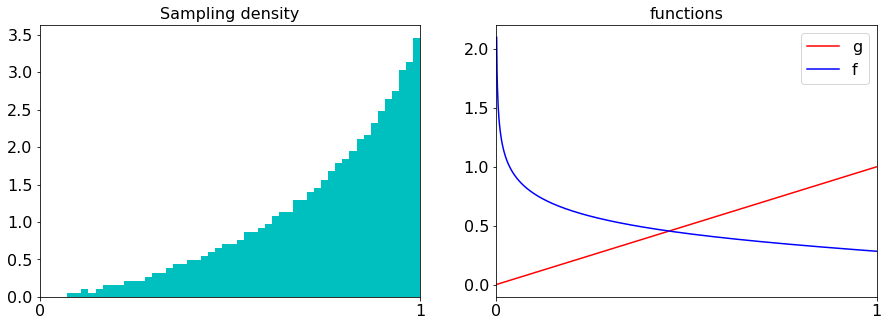

In [9]:
x = linspace(0,1,1000).reshape(-1,1)
x = x[1:-1] # plotting locations
# plot
fig,ax = pyplot.subplots(ncols=2,figsize=(15,5))
#    density
tfvals = cf.true_measure.transform._transform_r(x)
ax[0].hist(tfvals,density=True,bins=50,color='c')
ax[0].set_title('Sampling density')
#    functions
gs = cf.g(x)
fs = cf.f(x)
ax[1].plot(x,gs,color='r',label='g')
ax[1].plot(x,fs,color='b',label='f')
ax[1].legend()
for i in range(2):
    ax[i].set_xlim([0,1])
    ax[i].set_xticks([0,1])
ax[1].set_title('functions');

## Can we Improve the Keister function?

In [10]:
abs_tol = 1e-4
d = 1

In [11]:
# standard method
keister_std = Keister(Sobol(d))
sol_std,data_std = CubQMCSobolG(keister_std,abs_tol=abs_tol).integrate()
data_std

Solution: 1.3804         
Keister (Integrand Object)
Sobol (DiscreteDistribution Object)
    d               1
    randomize       1
    graycode        0
    seed            57958
    mimics          StdUniform
    dim0            0
Lebesgue (TrueMeasure Object)
    transform       Gaussian (TrueMeasure Object)
                       mean            0
                       covariance      2^(-1)
                       decomp_type     pca
CubQMCSobolG (StoppingCriterion Object)
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
LDTransformData (AccumulateData Object)
    n_total         2^(14)
    solution        1.380
    error_bound     1.58e-05
    time_integrate  0.011

In [12]:
# Kumaraswamy importance sampling
dd = Sobol(d,seed=7)
t1 = Kumaraswamy(dd,a=.8,b=.8) # first transformation
keister_kuma = Keister(Gaussian(t1,covariance=1/2))
sol_kuma,data_kuma = CubQMCSobolG(keister_kuma,abs_tol=abs_tol).integrate() 
print(data_kuma)

Solution: 1.3804         
Keister (Integrand Object)
Sobol (DiscreteDistribution Object)
    d               1
    randomize       1
    graycode        0
    seed            61616
    mimics          StdUniform
    dim0            0
Lebesgue (TrueMeasure Object)
    transform       Gaussian (TrueMeasure Object)
                       mean            0
                       covariance      2^(-1)
                       decomp_type     pca
                       transform       Kumaraswamy (TrueMeasure Object)
                                          a               0.800
                                          b               0.800
CubQMCSobolG (StoppingCriterion Object)
    abs_tol         1.00e-04
    rel_tol         0
    n_init          2^(10)
    n_max           2^(35)
LDTransformData (AccumulateData Object)
    n_total         2^(11)
    solution        1.380
    error_bound     9.59e-05
    time_integrate  0.004


In [13]:
t_frac = data_kuma.time_integrate/data_std.time_integrate
n_frac = data_kuma.n_total/data_std.n_total
print('Kuma importance sampling took %.1f%% of the time and %.1f%% of the samples compared to default keister.'%(t_frac*100,n_frac*100))

Kuma importance sampling took 39.5% of the time and 12.5% of the samples compared to default keister.


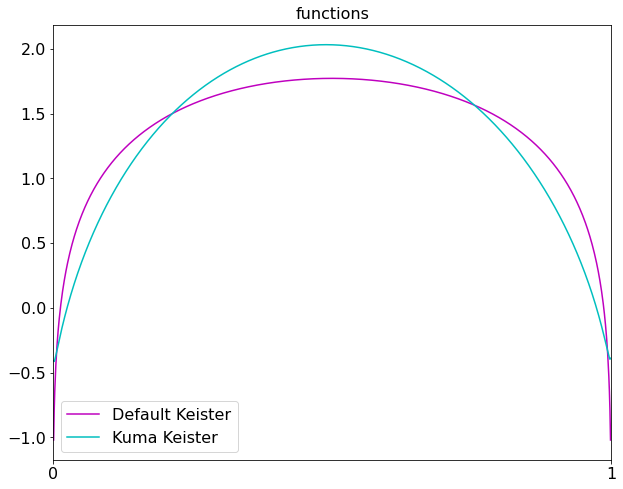

In [14]:
x = linspace(0,1,1000).reshape(-1,1)
x = x[1:-1] # plotting locations
# plot
fig,ax = pyplot.subplots(figsize=(10,8))
#    functions
fs = [keister_std.f,keister_kuma.f]
labels = ['Default Keister','Kuma Keister']
colors = ['m','c']
for f,label,color in zip(fs,labels,colors): ax.plot(x,f(x),color=color,label=label)
ax.legend()
ax.set_xlim([0,1])
ax.set_xticks([0,1])
ax.set_title('functions');